In [1]:
import scipy.io
import numpy as np

import pandas as pd
# pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import matplotlib.pyplot as plt
import seaborn as sns

import random
import math
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

# people.uncw.edu/hermanr/latex

In [2]:
group = "senate"
dataframe_mat = data_house_mat = scipy.io.loadmat(f"Data/processed data_{group}.mat")

In [3]:
vote_rc = pd.DataFrame(
    data = dataframe_mat['V_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
)
leader_rc = pd.DataFrame(
    data = dataframe_mat['leader_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc'][0]))] # 1st row as the column names
)
whip_rc = pd.DataFrame(
    data = dataframe_mat['whip_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc'][0]))] # 1st row as the column names
)
party_list = pd.DataFrame(
    data = dataframe_mat['party_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
)
congress_list = pd.DataFrame(
    data = dataframe_mat['congress_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
)

### 1. Data Preproccessing

In [4]:
print("House statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
congresses_involved = 1

print(f"Number of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses)")
print(f"Number of deputies overall = {party_list.size}")

vote_congress = vote_rc.iloc[:,0:bills_per_congress[0:congresses_involved].sum()].dropna(how='all')
vote_congress_array = np.array(vote_congress)

party_list_congress = party_list.loc[vote_congress.index]
party_list_congress_array = np.array(party_list_congress).flatten()

leader_rc_congress = leader_rc.iloc[:,0:bills_per_congress[0:congresses_involved].sum()].dropna(how='all')
leader_rc_congress_array = np.array(leader_rc_congress)

N = vote_congress.shape[0]
T = vote_congress.shape[1]

print(f"Number of bills in {congresses_involved} congress(es) = {T}")
print(f"Number of deputies in {congresses_involved} congress(es) = {N}")

House statistics
----------------
Number of bills overall = 25825 (46 congresses)
Number of deputies overall = 805
Number of bills in 1 congress(es) = 191
Number of deputies in 1 congress(es) = 101


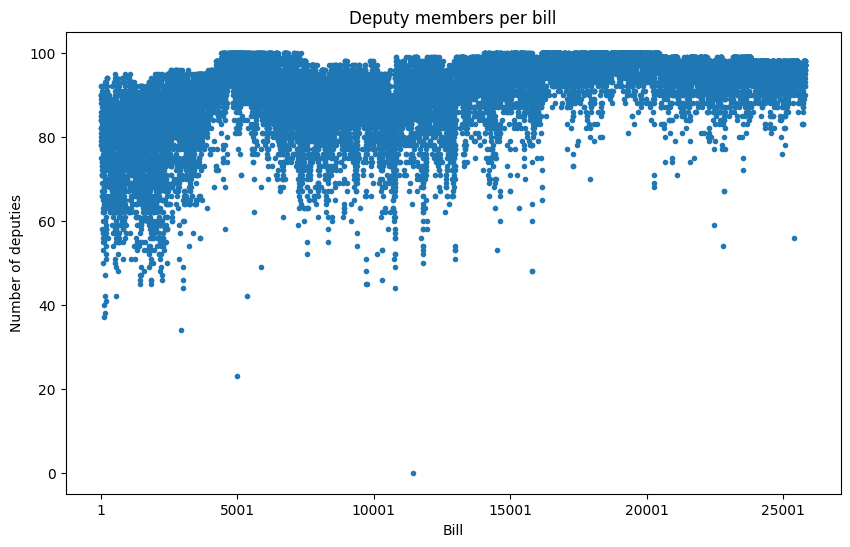

In [5]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

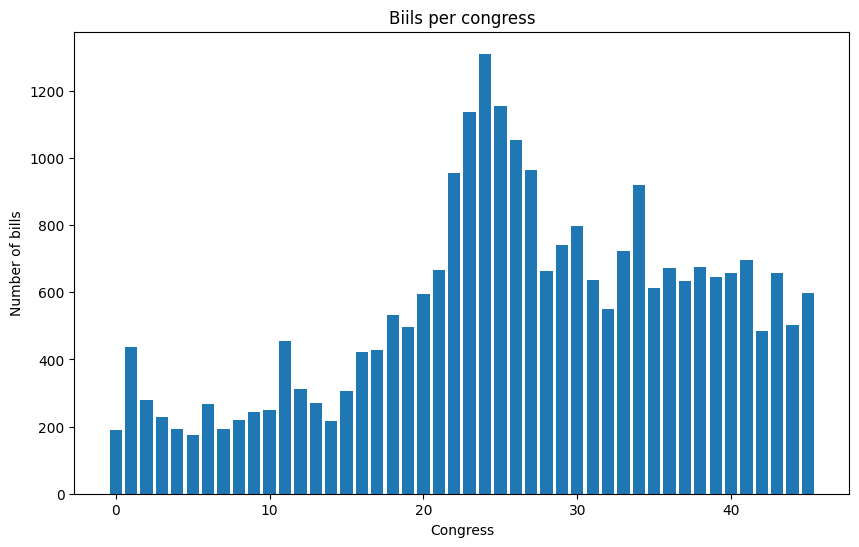

In [6]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

In [7]:
print(f"Nans in leader votes: {leader_rc_congress.isnull().sum().sum()}/{leader_rc_congress.size}")

# Replacing NaNs with te first value in each column
for column in leader_rc_congress.columns:
    for index in leader_rc_congress.index.values:
        if pd.isna(leader_rc_congress.loc[index,column]) == True:
            leader_rc_congress.loc[index,column] = leader_rc_congress.loc[leader_rc_congress.index.values[0],column]

print(f"Nans in leader votes after cleaning: {leader_rc_congress.isnull().sum().sum()}/{leader_rc_congress.size}")

Nans in leader votes: 1476/19291
Nans in leader votes after cleaning: 0/19291


### 2. Initial Guess

In [8]:
random.seed(112)

theta = np.array([[random.uniform(0,1),random.uniform(0,1)] for _ in range(N)])

# Normalize theta
theta = theta - theta[0]

if party_list_congress_array[0] == 100:
    # center Dems around 0 and GOP further right
	theta[1:] = [
    	theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5 
    	for i in range(1,len(theta))
    ]
else:
    # center GOP around 0 and Dems further left
    theta[1:] = [
    	theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5 
    	for i in range(1,len(theta))
    ]

# initialize ymax
ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

# initialize cutlines for bills
m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])
b = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

# construct a big parameter vector
omega_initial_guess = np.concatenate([theta.flatten(), ymax, m, b])

print(f"Parameters of the model: {len(omega_initial_guess)}")

Parameters of the model: 586


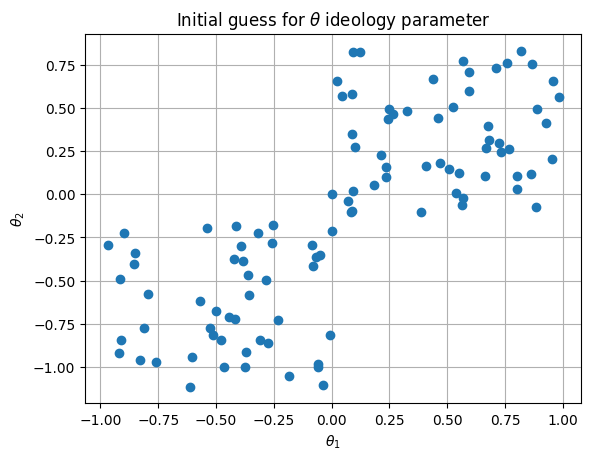

In [9]:
plt.plot(
    [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    "o"
)
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")
plt.show()

### 3. Likelihood Optimization

In [10]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [11]:
@njit
def likelihood(omega):
	# Unpack (decompose) parameter vector
	theta = np.zeros((N,2))
	ymax = np.zeros(2)
	m = np.zeros(T)
	b = np.zeros(T)

	for deputy in range(N):
		theta[deputy][0], theta[deputy][1] = omega[0 + 2*deputy], omega[1 + 2*deputy]

	ymax[0], ymax[1] = omega[0 + 2*N], omega[1 + 2*N]

	for bill in range(T):
		m[bill], b[bill] = omega[2*N + 2 + bill], omega[2*N + 2 + T + bill]
  
	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:
			whip_party = int(not(
				bool(vote_congress_array[deputy][bill]) ^ bool(leader_rc_congress_array[deputy][bill])
			))
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)
			
			cdf_arg = np.sqrt(1 / (1 + m[bill]**2)) * (
				theta[deputy][1] - m[bill]*theta[deputy][0] - b[bill] + whip_party*ymax[party_id]
			)
			
			cdf_value_arg = norm_cdf(cdf_arg)
			cdf_value_neg_arg = norm_cdf(-cdf_arg)

			likelihood_0 = vote_congress_array[deputy][bill] * np.log(cdf_value_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_arg)
			likelihood_1 = vote_congress_array[deputy][bill] * np.log(cdf_value_neg_arg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_neg_arg)
			if likelihood_0 >= likelihood_1:
				likelihood_value += likelihood_0
			else:
				likelihood_value += likelihood_1

	return likelihood_value

In [12]:
start_time = time.time()
likelihood(omega_initial_guess)
end_time = time.time()
print(f"Time of one execution = {round(end_time-start_time,4)} s")

Time of one execution = 4.5296 s


In [27]:
result = minimize(
	fun = lambda omega: -likelihood(omega),
	x0 = omega_initial_guess,
	method = "BFGS", # "SLSQP", "Nelder-Mead", "BFGS"
 	tol = 1e-2
)

In [28]:
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: nan
        x: [-6.362e+01  1.252e+02 ... -1.028e+03  1.776e+02]
      nit: 2
      jac: [       nan        nan ...        nan        nan]
 hess_inv: [[ 1.000e+00 -3.440e-05 ...  3.015e-05  2.230e-05]
            [-3.440e-05  9.999e-01 ...  7.598e-05  7.240e-05]
            ...
            [ 3.015e-05  7.598e-05 ...  1.000e+00 -6.564e-05]
            [ 2.230e-05  7.240e-05 ... -6.564e-05  1.000e+00]]
     nfev: 66918
     njev: 114

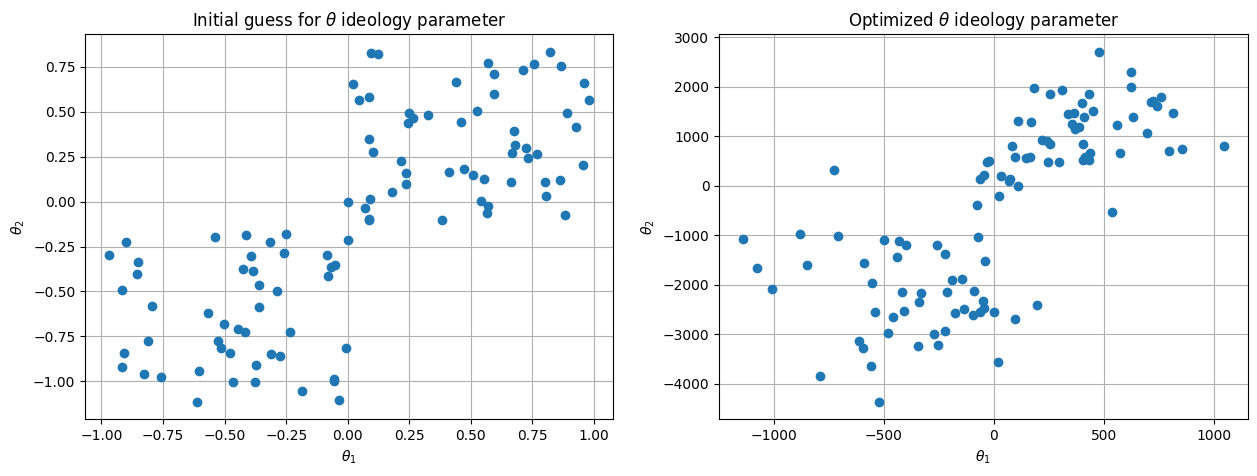

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(
    [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    "o"
)
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")

omega_hat = result.x

plt.subplot(1,2,2)
plt.plot(
    [omega_hat[0 + 2*deputy] for deputy in range(N)], 
    [omega_hat[1 + 2*deputy] for deputy in range(N)],
    "o"
)
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Optimized $\theta$ ideology parameter")

plt.show()